Device: cuda
Upload content image (clean):


Saving clean.jpg to clean (6).jpg
Optionally upload one extreme/style image. If you skip, the script will synthesize one from the content image.
Upload style image now (or click Cancel to skip):


Saving hidemotionblur.png to hidemotionblur (3).png


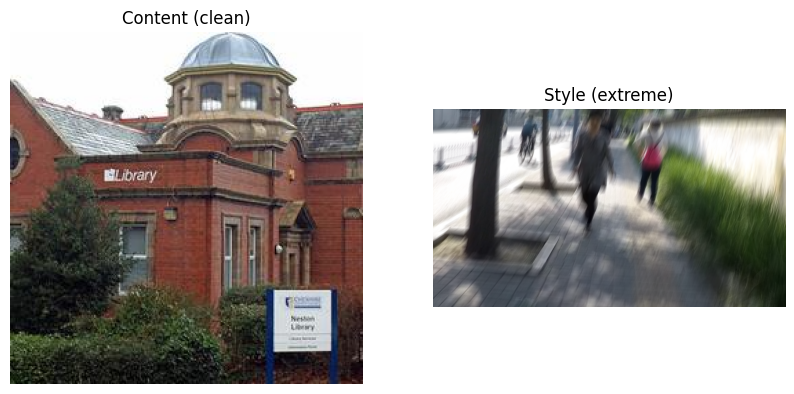

Running style-transfer (this may take several minutes depending on GPU)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


iter 699 L=496.3549 LPIPS=0.9163 SSIM=0.1701: 100%|██████████| 700/700 [01:09<00:00, 10.06it/s]


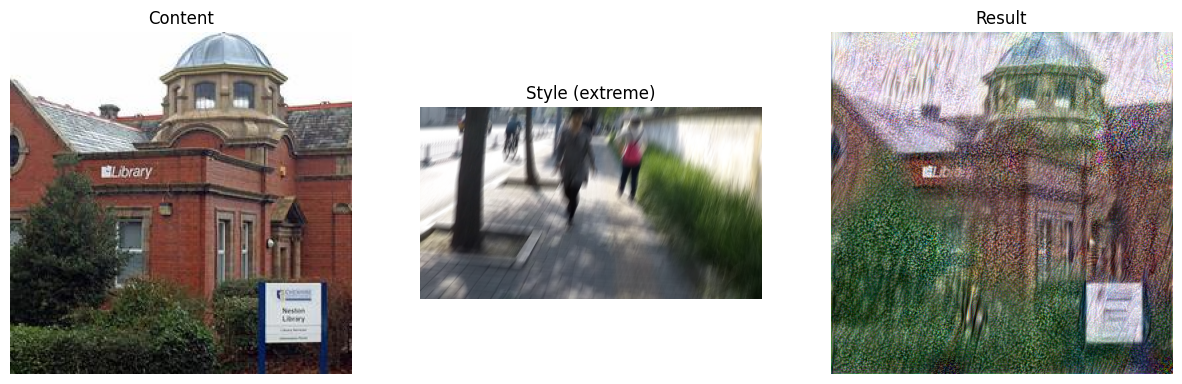

Saved result to style_aligned_result.png


In [ ]:
# Colab-ready PyTorch style-transfer with attention alignment
# Run in one cell in Colab. Requires GPU for reasonable speed.

# Install required packages (run once)
!pip install -q torch torchvision pillow tqdm lpips scikit-image matplotlib

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import lpips
from skimage.metrics import structural_similarity as ssim
import io, os, sys

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Utilities ----------
def load_image(path_or_bytes, target_size=None):
    """Load an image from path or bytes into tensor (1,C,H,W) in range [0,1]."""
    if isinstance(path_or_bytes, bytes):
        img = Image.open(io.BytesIO(path_or_bytes)).convert('RGB')
    else:
        img = Image.open(path_or_bytes).convert('RGB')
    if target_size is not None:
        img = img.resize(target_size, Image.LANCZOS)
    return img

def pil_to_tensor(img):
    tf = transforms.Compose([transforms.ToTensor()])
    return tf(img).unsqueeze(0).to(device)

def tensor_to_pil(tensor):
    t = tensor.detach().cpu().clamp(0,1).squeeze(0)
    return transforms.ToPILImage()(t)

def show_images(imgs, titles=None, figsize=(12,6)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i,img in enumerate(imgs):
        plt.subplot(1,n,i+1)
        if isinstance(img, torch.Tensor):
            plt.imshow(tensor_to_pil(img))
        else:
            plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    plt.show()

# ---------- Create an "extreme" shifted image function ----------
def make_extreme_shifted(img_pil, translate=(40,30), rotate=30, blur_radius=8, noise_std=0.2):
    """Return a heavily transformed 'extreme' version of the input PIL image."""
    w,h = img_pil.size
    # Translate by cropping and pasting
    tx, ty = translate
    # Create a larger canvas and paste shifted image
    canvas = Image.new('RGB',(w+abs(tx)+10, h+abs(ty)+10),(0,0,0))
    paste_x = max(tx, 0)
    paste_y = max(ty, 0)
    canvas.paste(img_pil, (paste_x, paste_y))
    # Crop back to original size (simulate shift that loses content)
    cropped = canvas.crop((0,0,w,h))
    # Rotate, blur
    rotated = cropped.rotate(rotate, resample=Image.BILINEAR, expand=False, fillcolor=(0,0,0))
    blurred = rotated.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    # Add heavy Gaussian noise
    arr = np.array(blurred).astype(np.float32) / 255.0
    noise = np.random.normal(0, noise_std, arr.shape).astype(np.float32)
    arr = np.clip(arr + noise, 0, 1)
    noisy = Image.fromarray((arr*255).astype(np.uint8))
    return noisy

# ---------- VGG feature extractor ----------
class VGGFeatures(nn.Module):
    """
    Extracts intermediate feature maps from VGG19.
    We'll use content layer 'conv4_2' and style layers conv1_1..conv5_1.
    """
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
        self.slices = {}
        # layer indices for common VGG layers
        self.layer_name_map = {
            '0': "conv1_1",
            '5': "conv2_1",
            '10': "conv3_1",
            '19': "conv4_1",
            '21': "conv4_2",  # content
            '28': "conv5_1"
        }
        self.vgg = vgg_pretrained
        if not requires_grad:
            for p in self.vgg.parameters():
                p.requires_grad = False

    def forward(self, x):
        features = {}
        for idx, layer in enumerate(self.vgg):
            x = layer(x)
            name = self.layer_name_map.get(str(idx))
            if name:
                features[name] = x
            # we can stop early if we got conv5_1
            if str(idx) == '28':
                break
        return features

# ---------- Losses ----------
def gram_matrix(x):
    b, c, h, w = x.size()
    feat = x.view(b, c, h*w)
    G = torch.matmul(feat, feat.transpose(1,2))
    return G / (c * h * w)

def attention_map_from_feature(fmap, eps=1e-8):
    """
    Compute a spatial attention map from feature map:
    - take L2 across channels -> (1, H, W)
    - normalize with softmax over spatial dims
    """
    # fmap: (B,C,H,W)
    att = torch.norm(fmap, p=2, dim=1, keepdim=True)  # (B,1,H,W)
    # flatten and softmax spatially
    b, _, h, w = att.shape
    att_flat = att.view(b, -1)
    att_norm = torch.softmax(att_flat, dim=1).view(b,1,h,w)
    return att_norm

# ---------- Main style transfer pipeline ----------
def style_transfer_with_attention(content_img_path, style_img_path,
                                   size=(512,512),
                                   iters=3000,
                                   content_weight=1e0,
                                   style_weight=1e3,
                                   att_weight=1e2,
                                   lr=0.02,
                                   use_init='content'):
    """
    content_img_path, style_img_path: paths to images
    Returns: generated image tensor (1,3,H,W)
    """
    # Preprocess
    content_t = pil_to_tensor(load_image(content_img_path, target_size=size))
    style_t = pil_to_tensor(load_image(style_img_path, target_size=size))
    # Normalization for VGG (ImageNet)
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    def normalize(x): return (x - mean) / std

    vgg = VGGFeatures().to(device)
    # target features: content & style
    style_feats = vgg(normalize(style_t))
    content_feats = vgg(normalize(content_t))

    # initialize generated image
    if use_init == 'content':
        gen = content_t.clone().requires_grad_(True)
    elif use_init == 'noise':
        gen = (torch.randn_like(content_t) * 0.1 + content_t*0.5).requires_grad_(True)
    else:
        gen = content_t.clone().requires_grad_(True)

    optimizer = optim.Adam([gen], lr=lr)

    # LPIPS model (for monitoring)
    loss_fn_alex = lpips.LPIPS(net='alex').to(device)

    pbar = tqdm(range(iters))
    run_losses = []
    for i in pbar:
        optimizer.zero_grad()
        gen_norm = normalize(gen)
        feats = vgg(gen_norm)

        # Content loss (MSE on conv4_2)
        content_loss = torch.nn.functional.mse_loss(feats['conv4_2'], content_feats['conv4_2'])

        # Style loss: Gram matrix on style layers
        style_loss = 0.0
        style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
        for l in style_layers:
            Gg = gram_matrix(feats[l])
            Gs = gram_matrix(style_feats[l])
            style_loss += torch.nn.functional.mse_loss(Gg, Gs)

        # Attention loss: match spatial attention map of a chosen layer (conv4_1)
        att_gen = attention_map_from_feature(feats['conv4_1'])
        att_style = attention_map_from_feature(style_feats['conv4_1'])
        att_loss = torch.nn.functional.mse_loss(att_gen, att_style)

        total_loss = content_weight * content_loss + style_weight * style_loss + att_weight * att_loss

        total_loss.backward()
        optimizer.step()

        # clamp generated to valid range
        with torch.no_grad():
            gen.clamp_(0,1)

        if (i % 50 == 0) or (i == iters-1):
            # compute metrics
            with torch.no_grad():
                # LPIPS (between content and generated) - lower means more perceptually similar
                lp_val = loss_fn_alex(content_t * 2 - 1, gen * 2 - 1).item()
                # SSIM between content and gen
                gen_img = tensor_to_pil(gen)
                content_img = tensor_to_pil(content_t)
                # convert to numpy arrays
                g_np = np.array(gen_img).astype(np.float32)/255.0
                c_np = np.array(content_img).astype(np.float32)/255.0
                # compute mean SSIM over channels
                # Add check for image size and specify win_size and channel_axis
                win_size = 7 # Default win_size, can be adjusted
                if min(g_np.shape[:2]) >= win_size:
                    ssim_val = ssim(c_np, g_np, win_size=win_size, channel_axis=2, data_range=1.0)
                else:
                    ssim_val = -1 # Indicate SSIM could not be computed
            pbar.set_description(f"iter {i} L={total_loss.item():.4f} LPIPS={lp_val:.4f} SSIM={ssim_val:.4f}")
        run_losses.append(total_loss.item())

    return gen.detach(), run_losses

# ---------- Evaluation helpers ----------
def compute_lpips(x, y):
    loss_fn = lpips.LPIPS(net='alex').to(device)
    return loss_fn(x*2-1, y*2-1).item()

def compute_ssim_pil(a_pil, b_pil):
    a = np.array(a_pil).astype(np.float32)/255.0
    b = np.array(b_pil).astype(np.float32)/255.0
    # Add check for image size and specify win_size and channel_axis
    win_size = 7 # Default win_size, can be adjusted
    if min(a.shape[:2]) >= win_size and min(b.shape[:2]) >= win_size:
        return ssim(a, b, win_size=win_size, channel_axis=2, data_range=1.0)
    else:
        return -1 # Indicate SSIM could not be computed


# ---------- User inputs: upload images or use sample ----------
print("Upload content image (clean):")
from google.colab import files
uploaded = files.upload()
if len(uploaded)==0:
    raise RuntimeError("Please upload at least one image file for content.")
content_path = list(uploaded.keys())[0]

print("Optionally upload one extreme/style image. If you skip, the script will synthesize one from the content image.")
print("Upload style image now (or click Cancel to skip):")
try:
    uploaded2 = files.upload()
    if len(uploaded2) > 0:
        style_path = list(uploaded2.keys())[0]
    else:
        # synthesize extreme from content
        base = load_image(content_path)
        style_img = make_extreme_shifted(base, translate=(120,80), rotate=35, blur_radius=10, noise_std=0.35)
        # Save synthesized image to a temporary file and use that path
        style_path = "synthesized_style.png"
        style_img.save(style_path)
        print(f"Synthesized extreme shifted style image from content and saved to {style_path}.")

except Exception as e:
    # Handle the case where cancel is clicked or other errors occur during upload
    base = load_image(content_path)
    style_img = make_extreme_shifted(base, translate=(120,80), rotate=35, blur_radius=10, noise_std=0.35)
    # Save synthesized image to a temporary file and use that path
    style_path = "synthesized_style.png"
    style_img.save(style_path)
    print(f"Synthesized extreme shifted style image from content and saved to {style_path}.")


content_img = load_image(content_path) # Load PIL image for showing
style_img = load_image(style_path) # Load PIL image for showing


# Show inputs
show_images([content_img, style_img], titles=['Content (clean)', 'Style (extreme)'], figsize=(10,5))

# Run style transfer
print("Running style-transfer (this may take several minutes depending on GPU)...")
out_t, losses = style_transfer_with_attention(content_path, style_path, size=(512,512), iters=700,
                                             content_weight=0.001, style_weight=1e6, att_weight=1e6, lr=0.02)

# Show final result
out_pil = tensor_to_pil(out_t)
show_images([content_img, style_img, out_pil], titles=['Content','Style (extreme)','Result'], figsize=(15,6))

# Save result
out_pil.save("style_aligned_result.png")
print("Saved result to style_aligned_result.png")